# 2. Building a machine learning pipeline

## Overview 
Having explored the data and defined the problem, we are ready to build an initial pipeline, with choices informed by our data exploration.

### Prerequisites

* Same as notebook 1 in this tutorial series, plus successful completion of notebook 1

### Learning Outcomes 
* Understand the fundamental steps in a machine learning pipeline
* Understand key terminology in describing the machine learning pipeline
* Initial understanding of how to choose appropriate components for each stage in the pipeline.

### Best Practices & Values
Values and Best Practices for using Machine Learning at the Met Office is a document which provides guidance various topics to consider when developing machine learning models, including:

* [Data quality](https://metoffice.sharepoint.com/:w:/r/sites/MetOfficeDataScienceCommunity/Shared%20Documents/MLAG/project_evaluation_review/MachineLearningBestPracticesAndValues_v1_0.docx?d=wae2554217d0342f2a9c8cf8906bfbe38&csf=1&web=1&e=2SpcXn&nav=eyJoIjoiNDEyNTAwMjQ1In0%3D)

* [Ethics](https://metoffice.sharepoint.com/:w:/r/sites/MetOfficeDataScienceCommunity/Shared%20Documents/MLAG/project_evaluation_review/MachineLearningBestPracticesAndValues_v1_0.docx?d=wae2554217d0342f2a9c8cf8906bfbe38&csf=1&web=1&e=atJUwf&nav=eyJoIjoiMTMxNzQ5MjMxNCJ9)

* [ML lifecycle](https://metoffice.sharepoint.com/:w:/r/sites/MetOfficeDataScienceCommunity/Shared%20Documents/MLAG/project_evaluation_review/MachineLearningBestPracticesAndValues_v1_0.docx?d=wae2554217d0342f2a9c8cf8906bfbe38&csf=1&web=1&e=IsoVYA&nav=eyJoIjoiMTQwMzgxMjIzNSJ9)

## Tutorial - Key Elements of a Machine Learning Pipeline

Using a series of data science and machine learning and algorithms to go from input data to a series of predictions is usually referred to as a pipeline.  In this noteboook we will be exploring the key components of such a pipeline in constructing and training a machine learning algorithm with some input data.

In this notebook we will look at 2 pipeline, one for a **supervised** **classification** problem, and the other for an **unsupervised** clustering problem.

The steps we willl go through are as follows:
* **Data Loading & Cleaning** - Start by loading the data, and filtering out any data considered to be unsuitable training and evaluation of machine learning algorithms. Selection of appropriate data is an important way in which domain expertise in vital in getting good results.
* **Feature Engineering** - The first step is to prepare the data for presenting to the algorithm. Different ways of presenting the data will emphasise different features, and choosing the *right features* is important for getting good results. Knowledge of what features represent based on domain knowledge is again very important.
* **Train/test Split** - Before we train the algorithm, we need to split into *train* and *test* sets. This is to ensure out algorithm doesn't *overfit*, learning irrelevant details that are not representative of the whole space of possible data, but rather that in generalises well.
* **Data Preparation** - The machine learning algorithm only sees numbers as numbers, with no inherent understanding of meaning or context. We need to ensure different features are scaled to be comparable, otherwise big numbers will be treated as more important by the algorithm, irrespective of what those numbers mean. Value are typically scaled to a range of `[0,1]` or, assuming a gaussian distribution, to have `mean=0` and `std_dev=1`.
* **Algorithm Setup** - Here we select the particular algorithm e,.g. neural network, k-means clustering, and specify the *hyperparameters*. It is important to distinguish between *parameters* and *hyperparameters*. 
  * Parameters are the values that calculated by the training process. 
  * Hyperparameters are values specified in algorithm setup, which are not altered by training. These need to be fine-tuned using an additional outer training loop called hyperparameter tuning.
* **Algorithm Training** - Execute the algorithm to calculate the best parameters for the chosen ML algorithm to fit the supplied training data
* **Inference** - Once we have an algorithm, we use it to produce predictions, for both the train and test sets.
* **Evaluation** - We then compare the predictions of the trained algorithms to expected results. For supervised learning, this will be supplied target values. For unsupervised learning, we will explore the results and their usefulness much like in exploratory data analysis.
* **Interpretability & Explainability**  - Machine learning models are often treated as black-boxes, that is we can't know or understand how or why the algoriothm produces a particular output. Explainability and interpretability aim to change this, giving insight on the internals of the algorithms (explainability) and guidance on interpeting a particular result (interpretability).
* **Model Storage** - Model training can be an expensive process that we don't want to perform too often, and. once we have a model that performs well we save its state so it can be reloaded and used subsequently for inference on later problems.


### Best Practices and Values
The topics covered and the examples demonstrated in this notebook related to the themes of the Met Office machine learning best practices and values in the following ways
* Ethics - Our algorithm development need to be transparent and justifiable.
* Data - We need to consider how we use the data, as well as which data will give us the best results. More data is not always better. Rather select data that is good quality and fits the requirements of the problem
* ML Lifecycle - Ensure we have a reproducible workflow. Save the trained model in a way that can easily be reused for inference.
* Interpretability and Explainability - Use a simpler algorithm where possible if this will help exlain and interpret the results
* ML Pitfalls - Ensure the loss function represents the real world requirements and impact of business need to get ML results that deliver value.


### Key Terms

* supervised learning - training an algorithm to map from input to target data or labels.
* unsupervised learning - training an algorithm to find structure in data that has no labels.
* regression - An algorithm that predicts a continuous values.
* classification - An algorithm that predicts from a set of discrete values
* metric - A measure of the performance of the ML algorithm.
* parameter - A value in the algorithm that is determined by the training process e.g. neural network weights or decision tree thresholds.
* hyperparameter - A value in the algorithm that is not determined by training and must be specified or tuned. e.g. number of hidden layers or max number of decision tree levels.
* feature engineering - the process of creating input variables for the ML aglorithm that will give desirable results.
* training set - The subset of your data that you use for training your algorithm.
* validation set - The subset of your data that you use for testing your trained algorithm and which informs subsequent development to improve results.
* test set - The subset of your data that you set aside and do not use while developing the algorithm. Once the development process is finished, you check the final result with this subset of the data to check it truly generalises to unseen data.
* inference - Calculating predictions from input data used a trained algorithm.

More information on jargon
* [Google Machine Learning Glossary](https://developers.google.com/machine-learning/glossary)
* [ML Cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/glossary.html)

## Exercise 1: Supervised Classification - Falkland Islands Rotor Prediction

### Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
import datetime
import os
import functools
import math

In [3]:
import matplotlib
%matplotlib inline

In [4]:
import numpy
import pandas

In [5]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy


In [6]:
import sklearn
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble
import sklearn.cluster
import sklearn.decomposition

### Load Rotors Data

In [7]:
try:
    falklands_data_dir = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ml_tutorial/'
falklands_data_dir = pathlib.Path(falklands_data_dir) 
print(falklands_data_dir)

/project/informatics_lab/data_science_cop/ml_tutorial


In [8]:
print(falklands_data_dir.is_dir())
falklands_data_dir

True


PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial')

In [9]:
falklands_data_fname = '2021_met_office_aviation_rotors.csv'

In [10]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [11]:
falklands_data_path = falklands_data_dir / falklands_data_fname

In [12]:
print(falklands_data_path.is_file())
falklands_data_path

True


PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/2021_met_office_aviation_rotors.csv')

In [13]:
# skip the first row of the file when we load the data
falklands_df = pandas.read_csv(falklands_data_path, header=0).loc[1:,:]

Next we do the data cleaning and prep that we did in the previous notebook.

In [14]:
# rename target variable
falklands_df = falklands_df.rename({'Rotors 1 is true': 'rotors_present'},axis=1)

In [15]:
# In the dataset, NaNs are used to represent that no rotors was observed. This is not good practice, so we are replacing the NaNs with 0's
falklands_df.loc[falklands_df[falklands_df['rotors_present'].isna()].index, 'rotors_present'] = 0

In [16]:
falklands_df[target_feature_name]  = falklands_df[target_feature_name] .astype(bool)

In [17]:
falklands_df[target_feature_name].value_counts()

rotors_present
False    19594
True       511
Name: count, dtype: int64

In [18]:
#  Create date and times using the pandas datetime functionality
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'],dayfirst=True)

# There are some duplicate dates and times, so we drop those
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])

# get rid of data points without a date and time
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]


In [19]:
falklands_df['time'] = falklands_df['DTG']

In [20]:
falklands_df['time']

1       2015-01-01 00:00:00
2       2015-01-01 03:00:00
3       2015-01-01 06:00:00
4       2015-01-01 09:00:00
5       2015-01-01 12:00:00
                ...        
20101   2020-12-31 06:00:00
20102   2020-12-31 09:00:00
20103   2020-12-31 12:00:00
20104   2020-12-31 15:00:00
20105   2021-01-01 00:00:00
Name: time, Length: 17507, dtype: datetime64[ns]

In [21]:
#  subset observation so that wind speed, air temp, wind direction and dewpoints
# are all greater than 0  (temperatures are in Kelvin, which must be greater than 0)
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]

In [22]:
falklands_df

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present,time
1,1,2015-01-01 00:00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,False,2015-01-01 00:00:00
2,2,2015-01-01 03:00:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,False,2015-01-01 03:00:00
3,3,2015-01-01 06:00:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,False,2015-01-01 06:00:00
4,4,2015-01-01 09:00:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,False,2015-01-01 09:00:00
5,5,2015-01-01 12:00:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,...,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,False,2015-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,2020-12-31 06:00:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,False,2020-12-31 06:00:00
20102,20102,2020-12-31 09:00:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,False,2020-12-31 09:00:00
20103,20103,2020-12-31 12:00:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,False,2020-12-31 12:00:00
20104,20104,2020-12-31 15:00:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,False,2020-12-31 15:00:00


In [23]:
list(falklands_df.columns)

['Unnamed: 0',
 'DTG',
 'air_temp_obs',
 'dewpoint_obs',
 'wind_direction_obs',
 'wind_speed_obs',
 'wind_gust_obs',
 'air_temp_1',
 'air_temp_2',
 'air_temp_3',
 'air_temp_4',
 'air_temp_5',
 'air_temp_6',
 'air_temp_7',
 'air_temp_8',
 'air_temp_9',
 'air_temp_10',
 'air_temp_11',
 'air_temp_12',
 'air_temp_13',
 'air_temp_14',
 'air_temp_15',
 'air_temp_16',
 'air_temp_17',
 'air_temp_18',
 'air_temp_19',
 'air_temp_20',
 'air_temp_21',
 'air_temp_22',
 'sh_1',
 'sh_2',
 'sh_3',
 'sh_4',
 'sh_5',
 'sh_6',
 'sh_7',
 'sh_8',
 'sh_9',
 'sh_10',
 'sh_11',
 'sh_12',
 'sh_13',
 'sh_14',
 'sh_15',
 'sh_16',
 'sh_17',
 'sh_18',
 'sh_19',
 'sh_20',
 'sh_21',
 'sh_22',
 'winddir_1',
 'windspd_1',
 'winddir_2',
 'windspd_2',
 'winddir_3',
 'windspd_3',
 'winddir_4',
 'windspd_4',
 'winddir_5',
 'windspd_5',
 'winddir_6',
 'windspd_6',
 'winddir_7',
 'windspd_7',
 'winddir_8',
 'windspd_8',
 'winddir_9',
 'windspd_9',
 'winddir_10',
 'windspd_10',
 'winddir_11',
 'windspd_11',
 'winddir_12',
 '

In [24]:
falklands_df[target_feature_name].value_counts()

rotors_present
False    17037
True       449
Name: count, dtype: int64

## Feature Engineering

Having loaded the data, the next step is to prepare the features we want to use as the inputs to our ML model. Some of these may be already present in the dataset, others will be calculated from those present.

The input features for our ML model will be 
* *air temperature* - present in the dataset
* *specific humidity* - present in the dataset
* *u & v wind* - calculated from wind speed and direction. We will use these parameters as they will vary more smoothly that speed & direction for northerly winds, which is the wind we are interested in.

The steps in the feature engineering to produce these features are as follows:
* Specify feature names
* convert wind speed / direction back to u/v wind. 
* prepare the target variable, including filling in missing data.

specify the name of the observation features

Define functions for calculating u and v wind.

In [25]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

Add the new u and v wind features to the dataframe.

In [26]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

CPU times: user 9.72 s, sys: 1.49 s, total: 11.2 s
Wall time: 11.2 s


In [27]:
obs_names = [
    'air_temp_obs',
    'dewpoint_obs',
    'wind_speed_obs',
    'wind_direction_obs',
]

obs_feature_names = [
    'air_temp_obs',
    'dewpoint_obs',
]

Now calculate the U and V wind features, but for the observations (as opposed to model output data).

In [28]:
wdn1 = 'wind_direction_obs'
wsn1 = 'wind_speed_obs'
u_feature = u_feature_template.format(level_ix='obs')
obs_feature_names += [u_feature]
falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
v_feature = v_feature_template.format(level_ix='obs')
obs_feature_names += [v_feature]
falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [29]:
falklands_df[obs_feature_names]

,air_temp_obs,dewpoint_obs,u_wind_obs,v_wind_obs
1,283.9,280.7,3.852740,-1.402283e+00
2,280.7,279.7,7.700000,4.714890e-16
3,279.8,278.1,7.583020,-1.337091e+00
4,279.9,277.0,6.235383,-3.600000e+00
5,279.9,277.4,7.534421,-4.350000e+00
...,...,...,...,...
20101,276.7,275.5,-3.600000,-6.613093e-16
20102,277.9,276.9,-3.100000,-5.694608e-16
20103,283.5,277.1,-2.314035,-2.757760e+00
20104,286.1,276.9,-3.382893,-1.231273e+00


In [30]:
falklands_df[target_feature_name]

1        False
2        False
3        False
4        False
5        False
         ...  
20101    False
20102    False
20103    False
20104    False
20105    False
Name: rotors_present, Length: 17486, dtype: bool

In [31]:
falklands_df[target_feature_name].value_counts()

rotors_present
False    17037
True       449
Name: count, dtype: int64

### Train/test Split

Splitting data into train/validation/test sets

To consider 
* consistency of distributions
* class imbalance
* correlation between samples


#### Option 1 - Random split

An initial option might be to split randomly, using the built-in scikit learn functionality. We specify a test fraction, which is the proportion of the dataset that will be in the test split. For example if we choose a fraction of `0.2`, then 20% of the data point will be randomly selected for the test set, and the rest (80%) of the data will be assigned to the train set.

In [32]:
test_fraction = 0.2

In [33]:
# Each observation is randomly allocated to train or test, with the test dataset having 20% of the data
train_random_df, test_random_df = sklearn.model_selection.train_test_split(falklands_df)
train_random_df.shape, test_random_df.shape

((13114, 143), (4372, 143))

In [34]:
# Investigate number of rotors in the training dataset
train_random_df[target_feature_name].value_counts()

rotors_present
False    12765
True       349
Name: count, dtype: int64

In [35]:
# Investigate number of rotors in the test dataset
test_random_df[target_feature_name].value_counts()

rotors_present
False    4272
True      100
Name: count, dtype: int64

#### Option 2 - Split each class separately
We know that our 2 classes (rotor detected/ no rotor detected) are **imbalanced**, so we might want to select from each class, to ensure our train/test splits have distributions which reflect the larger distribution. Our randomly selected train/test split likely preserved the rotor/no rotor ratio quite well, but it may not, so we can do the split in a way that expicitly preserves the distribution of classes. For this we will use the pandas `sample()` function to select the test set, and select a fraction from each class separately.

In [36]:
num_no_rotors = sum(falklands_df[target_feature_name] == False)
num_with_rotors = sum(falklands_df[target_feature_name] == True)

In [37]:
num_no_rotors,num_with_rotors

(17037, 449)

First create a separate dataframe for each class (*rotors present* and *no rotors*). 

In [38]:
data_no_rotors = falklands_df[falklands_df[target_feature_name] == False]
data_with_rotors = falklands_df[falklands_df[target_feature_name] == True]

In the following cell, we create a new feature in the dataframe which labels the data as train or test. Its quite a dense piece of code, here is what is happening:
* Create a new column of the dataframe called `test_set` and set the value to false everywhere (indicating the point is not a part of the test set).
* For the dataframe repesenting each of the classes, sample a fraction of the datapoints  in the class determined by the `test_fraction` variable. In this case it is `0.2`, indicating that we will sample 20% of the data for each class. 
* get the indices of the sampled data points and create a list of the sampled inidices for each class.
* combine the lists
* at all the indices in the list, set the value of the `test_fraction` column to true, so that all the sampled points are now labelled as being a part of the test set.

In [39]:
falklands_df['test_set'] = False
falklands_df.loc[list(data_no_rotors.sample(frac=test_fraction).index) + list(data_with_rotors.sample(frac=test_fraction).index),'test_set'] = True

In [40]:
train_class_df = falklands_df[falklands_df['test_set'] == False]
test_class_df = falklands_df[falklands_df['test_set'] == True]

In [41]:
# Investigate number of rotors in the training data
train_class_df[target_feature_name].value_counts()

rotors_present
False    13630
True       359
Name: count, dtype: int64

In [42]:
# Investigate number of rotors in the test data
test_class_df[target_feature_name].value_counts()

rotors_present
False    3407
True       90
Name: count, dtype: int64

#### Option 3 - Split by time 
We also know though that data points from adjacent points in time are likely to be **correlated**. As a result data in our test set will be correlated with that in our train set if we split randomly. Instead for this problem, we should split by time. A common approach is to select whole years of data for train and test. For example, the ML weather models trained on ERA5 reanalsysis data typically use 2018 and after as their test set, and all the data for 2017 and before as the training set.

In [43]:
min(falklands_df['time']), max(falklands_df['time'])

(Timestamp('2015-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00'))

Looking at the time column, we see that the time range covered by our dataset includes all of the years from 2015 to 2020. So we might select the last year (2020) as our test set, and the rest of the the data as a training set.

In [44]:
train_df = falklands_df[falklands_df['time'] < datetime.datetime(2020,1,1,0,0)]
test_df = falklands_df[falklands_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [45]:
train_df[target_feature_name].value_counts()

rotors_present
False    14252
True       320
Name: count, dtype: int64

In [46]:
test_df[target_feature_name].value_counts()

rotors_present
False    2784
True      129
Name: count, dtype: int64

There are flaws to each of these approaches which we will need to bear in mind when choosing one of these approaches, or a different one.
* random - doesn't presevre class distributiuon, ay be correlations between samples in train and test which reduces confidence in result.
* per class - preserves distribution, may be correlation between train and test which reduces confidence in result.
* by time - doesn't preserve distribution. Additionally, the particular year may not be respresentative of the full dataset. For example if the phenomenon being predicted was affected by ENSO and the year chosen was an El Nino year.

### Data Preparation
Now we prepare the data for ingestion by the ML training process. This is a about the mechanics of ML algorithms, where values for different features need to be normalised so are they are considered equally important by the algorithm. 

In [47]:
falklands_df[temp_feature_names[0]].min(), falklands_df[temp_feature_names[0]].max()

(267.625, 298.25)

In [48]:
falklands_df[v_wind_features_names[0]].min(), falklands_df[v_wind_features_names[0]].max()

(-18.920766662381933, 16.79070179011734)

We see a very different range of values. The ML algorithm doesn't "understand" the different ranges of values, we need to ensure all values are in a similar range so they can all contribute to a prediction. Ultimately it is the value relative to other values thats important, rather than the absolute value (from an ML perspective) so we can normalise the distribution to being between 0 and 1, or have a 0 mean and standard deviation of 1, which we will do here. 

#### Preprocess by normalising the data

In [49]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [50]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(train_df[[if1]])
    preproc_dict[if1] = scaler1

In [51]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(train_df[[target_feature_name]])

LabelEncoder()

In [52]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])


In [53]:
X_train = preproc_input(train_df, preproc_dict)
y_train = preproc_target(train_df, target_encoder)

In [54]:
y_train.shape, X_train.shape

((14572,), (14572, 88))

In [55]:
sum(y_train == 1)

320

In [56]:
X_test = preproc_input(test_df, preproc_dict)
y_test = preproc_target(test_df, target_encoder)

In [57]:
y_test.shape, X_test.shape

((2913,), (2913, 88))

In [58]:
train_test_tuples = [
    (X_train, y_train),
    (X_test, y_test),    
]

# Algorithm Setup
Now that we've done the "data wrangling", we can finally move on to the machine learning specific parts of the project (recieved wisdom is that 80% of a ML poroject will be spent on data wrangling!). The first step is to set up objects representing the algorithms we will be training.

For this introductory example, where the emphasis is on the concepts, rather than the final trained algorothm, we are going to use [*scikit-learn*](https://scikit-learn.org/) which abstracts away some of the details so it is easier to see how the concepts translate into code. 

Another advantage is that all the different algorithms that are available through scikit-learn have a consistent interface, so we can use the same code to trian several different classifiers and compare their performance.

In this section we will specify which classifier we will use and the *hyper-parameters* for the different algorithms that will be trained. The actual training happens subsequently.

We will use two decision tree type algorithms, and then two neural networks of different sizes.  We will look in more detail at how these two sorts of algorithms work in a subsequent section of the tutorial.

In [59]:
classifiers_params = {
    'decision_tree': {'class': sklearn.tree.DecisionTreeClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
    'random_forest': {'class': sklearn.ensemble.RandomForestClassifier, 'opts': {'max_depth':10, 'class_weight':'balanced'}},
     'ann_5_500': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
     'ann_3_700': {'class': sklearn.neural_network.MLPClassifier, 'opts': {'hidden_layer_sizes':(700,700,700)}},   
}

In [60]:
%%time
classifiers_dict = {}             
for clf_name, clf_params in classifiers_params.items():
    clf1 = clf_params['class'](**clf_params['opts'])
    classifiers_dict[clf_name] = clf1

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 67 µs


## Algorithm Training
Now that everthing is set up, we can train the chosen algorithms with the data we have prepared. Through the scikit-learn interface, one can call `fit()` on the algorithm object, passing the input and target data as the arguments to the function.

In [61]:
%%time
for clf_name, clf1 in classifiers_dict.items():
    print(clf_name)
    clf1.fit(X_train, y_train)

decision_tree
random_forest
ann_5_500
ann_3_700
CPU times: user 55min 39s, sys: 469 ms, total: 55min 39s
Wall time: 7min 5s


## Inference
Once we have trained one or more ML algorithms, we then want to use them to make predictions. Using a trained to model to make a prediction is known as *inference*. Through the sci-kit learn interface, inference is down by calling the `predict()` function, passing the particular input dataset for which you want predictions. We will start by getting predictions for the training data (`X-train`) and comparing it to the correct answers. This will tell us how well the algorithm can predict with data it has learnt from and already seen.

Then we do the same for the test data, which it has not seen. This will tell us how well the training has captured the general problem of interest (forecasting rotors), and not just learnt about the particular dataset we trained on.

In [62]:
y_pred_train = {}

# iterate through each of the trained models to make a prediction for the training data
for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_train)
    y_pred_train[clf_name] = y_pred
    train_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(train_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes train set: {rotors_freq}')
    actual_freq = list(train_df[target_feature_name].value_counts())
    print(f'actual classes train set: {actual_freq}')

predicted classes train set: [12385, 2187]
actual classes train set: [14252, 320]
predicted classes train set: [12789, 1783]
actual classes train set: [14252, 320]
predicted classes train set: [14269, 303]
actual classes train set: [14252, 320]
predicted classes train set: [14255, 317]
actual classes train set: [14252, 320]


In [63]:
y_pred_test = {}

# iterate through each of the trained models to make a prediction for the test data
for clf_name, clf1 in classifiers_dict.items():
    y_pred = clf1.predict(X_test)
    y_pred_test[clf_name] = y_pred
    test_df[f'pred_{clf_name}'] = y_pred
    rotors_freq = list(test_df[f'pred_{clf_name}'].value_counts())
    print(f'predicted classes test set: {rotors_freq}')
    actual_freq = list(test_df[target_feature_name].value_counts())
    print(f'actual classes test set: {actual_freq}')

predicted classes test set: [2482, 431]
actual classes test set: [2784, 129]
predicted classes test set: [2567, 346]
actual classes test set: [2784, 129]
predicted classes test set: [2881, 32]
actual classes test set: [2784, 129]
predicted classes test set: [2852, 61]
actual classes test set: [2784, 129]


## Evaluation

To determine whether the algorithm is performing well, we need to measure the performance in some way. For supervised learning, metrics are divided by the two key types of problem: regression and classification. Whichever sort of algorithm you're using, getting good results depends on measuring the right thing that best reflects the real world impact, business need or physical reality of the system being studied. Choosing the wrong metric might result in a trained algorithm that seemingly performs well in development, but isn't actually that useful in the real world.

We're dealing with a classification problem here, so we will use classfication relevant metrics.
The obvious metric to use is accuracy i.e. how many predictions did we get right? As we will see, this  usually does represent the way want the algorithm to perform. Obviously we want all the predictions to be correct, but generally, some will be wrong. Depending on the impact of incorrect predictions, we may wish penalise certain mistakes more or less. Different sorts of metrics allow us to do that.
    
A common starting point is precision and recall. This is frequently confusing, and the [wikipedia page](https://en.wikipedia.org/wiki/Precision_and_recall) has numerous useful explanations and diagrams. 


* **Precision** is the portion of data points predicted as being in a class that are actually in that class.
  * In other words, `Precision = P( true positive / classified as positive)`
* **Recall** in the proportion of data points that are in a specific class in reality that are predicted as being in that class.
   * In other words, `Recall = P( correctly classified / total observed positive)`

In the diagram below the events in the circle are all the predicted events (eg, predicted rotors to happen). The left side of the square are the total number of actual events that occurred. 

![Precision and recall](images/Precisionrecall.svg)

Graphic taken from Wikipedia


In [64]:
prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train), 
)

print(f'precision={prec},\n recall={recall},\n f1-score={f1},\n support={support} ')


precision=[0.99983851 0.14540466],
 recall=[0.86886051 0.99375   ],
 f1-score=[0.92975936 0.25368967],
 support=[14252   320] 


Here we see that we have poor precision and good recall from decision tree. This means that we are predicting a high percentage of all actual rotor events, but we are also predicting as rotor events quite a lot of data points that are not actually rotor events.

F1-score combines precision and recall to create a balanced metric. 

$F_{1}= 2 * \frac{precision * recall}{precision + recall}$

The One in the name reflects equal weighting of precision and recall in the metric. We can start to come up with more sophisticated metrics by giving more weight to one or the other, in the $F_{\beta}$ metric

$F_{\beta} = (1 + \beta)^2 * \frac{precision * recall}{\beta^2 *precision + recall}$

Another way to look at the results is using a confusioin matrix, also referenced in the wikipedia page above. 

In [65]:
cm1 = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
)

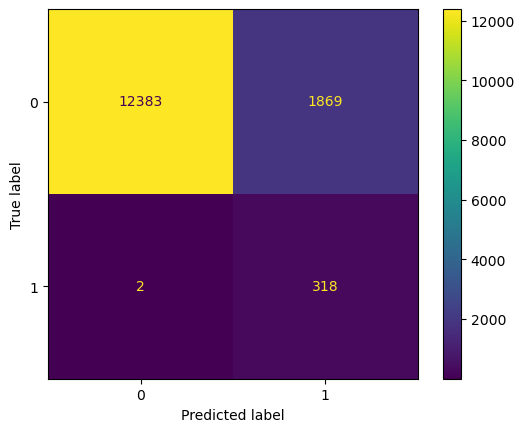

In [66]:
_ = sklearn.metrics.ConfusionMatrixDisplay(cm1).plot()

In [67]:
true_negatives, false_positives, false_negatives, true_positives = sklearn.metrics.confusion_matrix(
    y_train,
    classifiers_dict['decision_tree'].predict(X_train),
).ravel()
true_negatives, false_positives, false_negatives, true_positives

(12383, 1869, 2, 318)

The confusion matrix shows us where the algorithm correctly predicts Yes or No for a class, and where it gets it wrong.
* top left = true negative - Model predicts no rotors where none were observed
* top right = false postive (false alarm) - Model predicts rotors where no rotors were observed
* bottom left = false negative (miss) - Model predicts no rotors where rotors were actually observed
* bottom right = true positive (hit) - Model predicts rotors where rotors were observed


We can use this as the basis for other useful metrics. 

**Hit rate** is the proportion of data points where rotors were observed where rotors were actually predicted by the algorithm. The higher the hit rate, the more trust there will be in any positive predictions of rotors.

In [68]:
hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
hit_rate

0.99375

**False alarm rate** is proportion of data points where no rotors were observed where the model incorrectly predicted rotors.

In [69]:
false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
false_alarm_rate

0.13113948919449903

The question then, is what do we really care about in this problem? What sort of errors are the most impactful? In our case, it is very important not to miss any rotor events, so false negatives are very bad and should be penalised. False positive erode trust in the forecast, but it is less costly to predict a few events that don't happen than to miss any events at all. So we might consider the false alarm and the miss rate to be very important.

In [70]:
%%time 
metrics1 = []
# Calculate False Alarm and Miss rates for different algorithms and put into a dictionary.
for X1, y1 in train_test_tuples:
    md1 = {'classifier': [],
           'precision_noRotor': [], 'precision_rotor': [],
           'recall_noRotor': [], 'recall_rotor': [], 
           'f1_noRotor': [], 'f1_rotor': [], 
           'hit_rate': [], 'false_alarm_rate': []
          }
    for clf_name, clf1 in classifiers_dict.items():
        md1['classifier'] += [clf_name]
        prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(clf1.predict(X1), y1)
        md1['precision_noRotor'] += [prec[0]]
        md1['precision_rotor'] += [prec[1]]
        md1['recall_noRotor'] += [recall[0]]
        md1['recall_rotor'] += [recall[1]]
        md1['f1_noRotor'] += [f1[0]]
        md1['f1_rotor'] += [f1[1]]
        cm1 = sklearn.metrics.confusion_matrix(clf1.predict(X1), y1)
        hit_rate = cm1[1,1] / (cm1[1,1]+cm1[1,0])
        md1['hit_rate'] += [hit_rate]
        false_alarm_rate = cm1[0,1] / (cm1[0,1]+cm1[0,0])
        md1['false_alarm_rate'] += [false_alarm_rate]
    metrics1 += [md1]

CPU times: user 13.8 s, sys: 1.19 s, total: 15 s
Wall time: 1.97 s


In [71]:
train_metrics_df = pandas.DataFrame(metrics1[0])
test_metrics_df = pandas.DataFrame(metrics1[1])

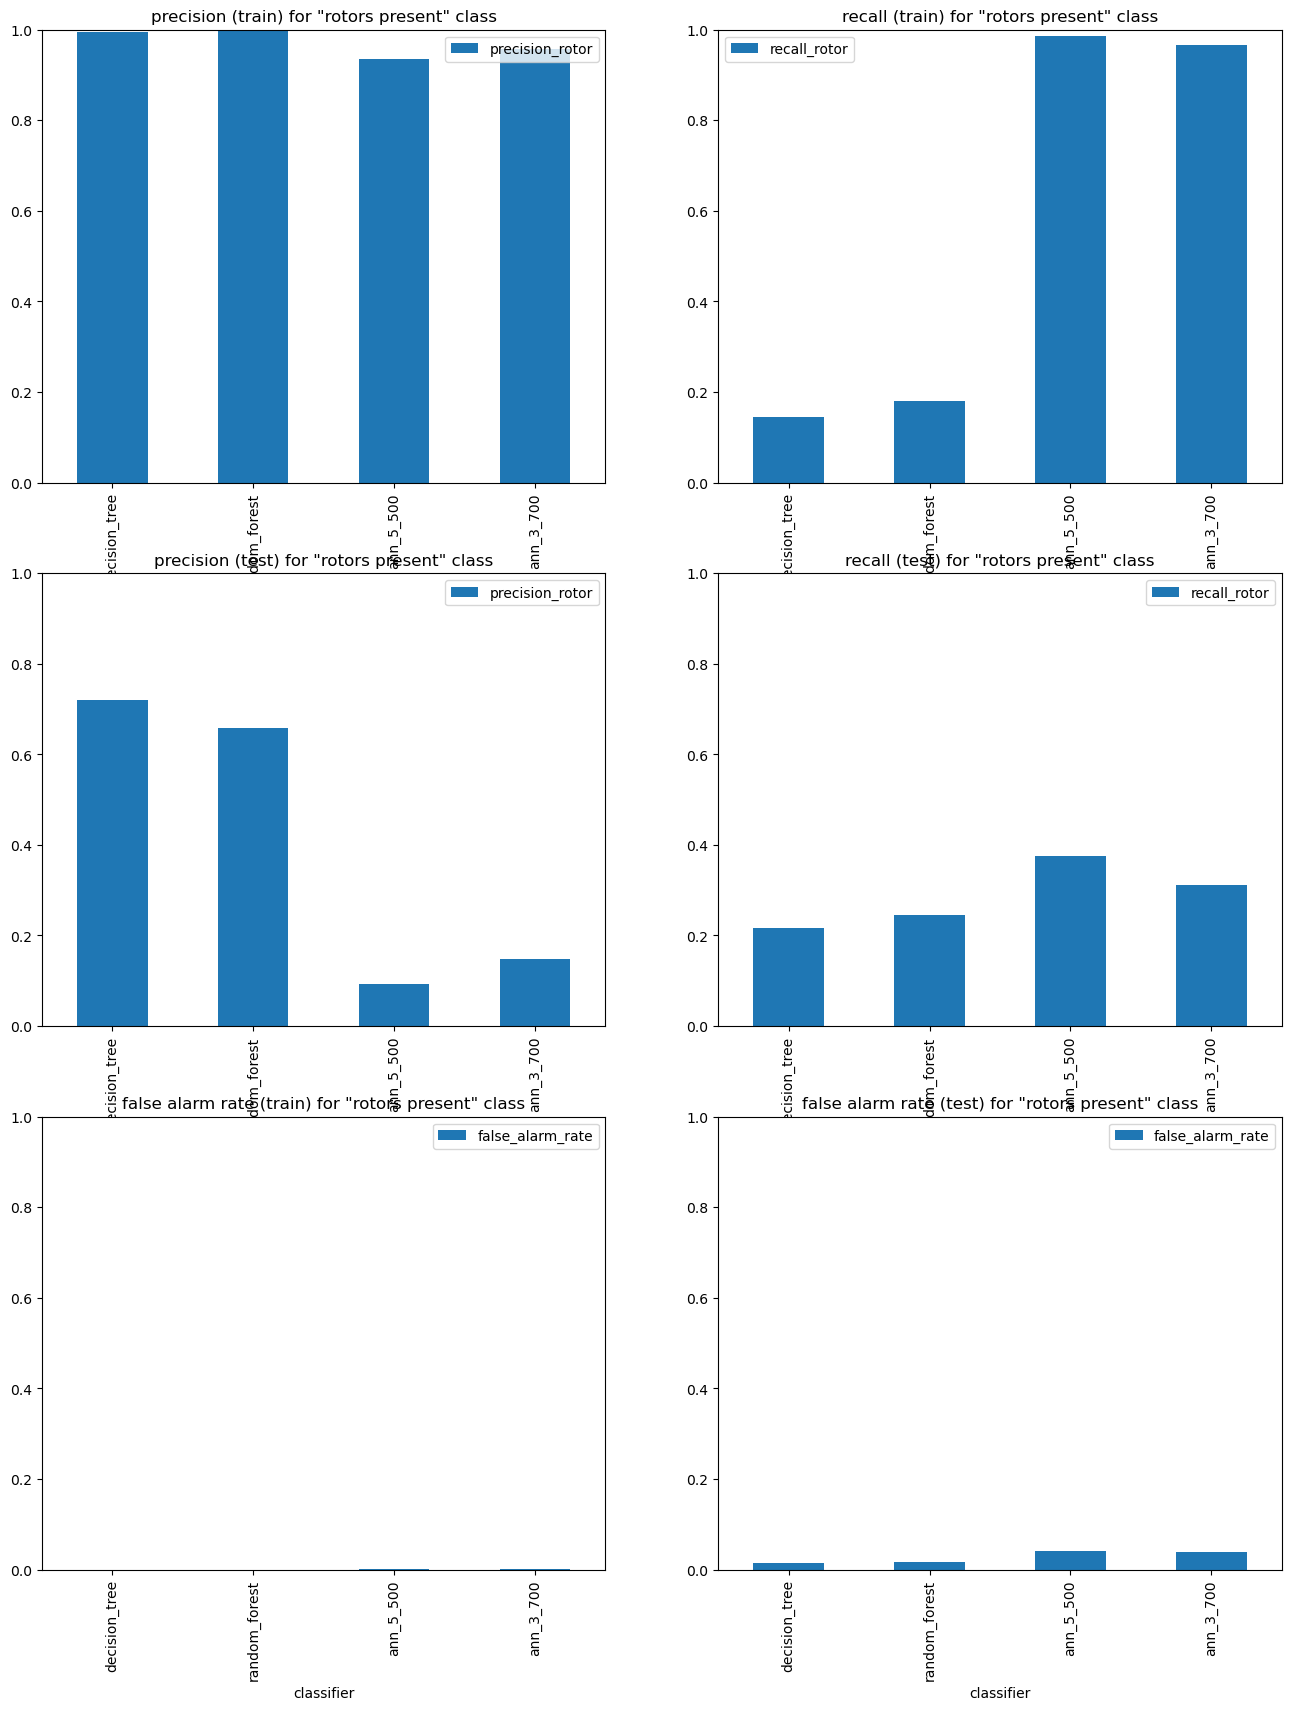

In [72]:
# Plot metrics for different algorithms
fig1 = matplotlib.pyplot.figure(figsize=(16,20))
ax1 = fig1.add_subplot(3,2,1,title='precision (train) for "rotors present" class')
train_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,2,title='recall (train) for "rotors present" class')
_ = train_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,3,title='precision (test) for "rotors present" class')
test_metrics_df.plot.bar(x='classifier', y='precision_rotor', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,4,title='recall (test) for "rotors present" class')
_ = test_metrics_df.plot.bar(x='classifier', y='recall_rotor', ax=ax1, ylim=[0,1])

ax1 = fig1.add_subplot(3,2,5,title='false alarm rate (train) for "rotors present" class')
train_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])
ax1 = fig1.add_subplot(3,2,6,title='false alarm rate (test) for "rotors present" class')
_ = test_metrics_df.plot.bar(x='classifier', y='false_alarm_rate', ax=ax1, ylim=[0,1])

In [73]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

How though do we actually go about getting better results? One way for this is to understand that some algorithms output a pseudo-probability, and the classification is based on thesholding that value. By altering the threshold we get different predictions and thus different metric results.

In [74]:
y_train_pred_raw = classifiers_dict['random_forest'].predict_proba(X_train)[:,1]
y_test_pred_raw = classifiers_dict['random_forest'].predict_proba(X_test)[:,1]

In [75]:
thresholds_list = list(numpy.arange(1e-3,0.995,5e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in thresholds_list:
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train, y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

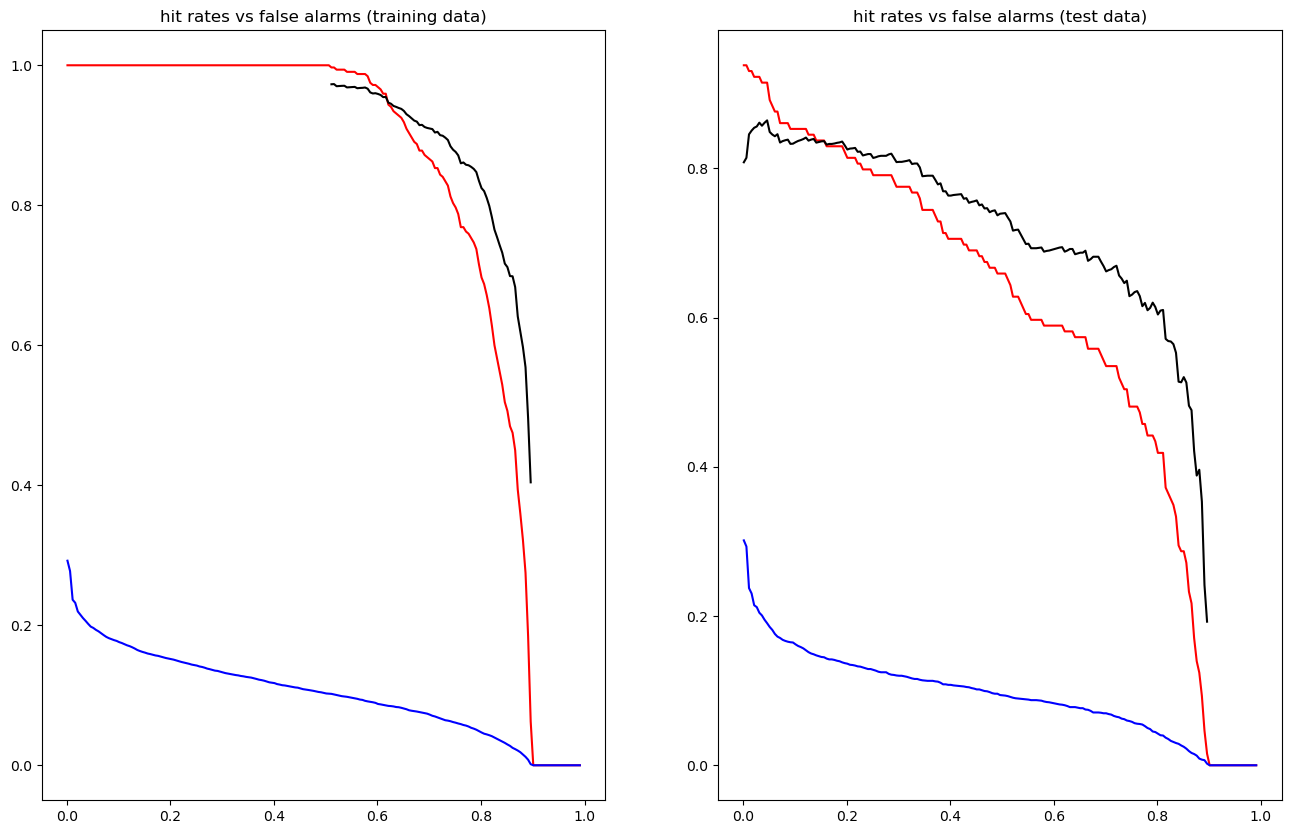

In [76]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

## Model Storage

Once we have trained a model, we usually want to save the result for subsequent use in scientific work. There are a variety of ways of doing this. The most simple way in scikit learn is to pickle the data.

Different models have different elements that need to be stored. Some examples include:

* Decision tree - The nodes, the connections between nodes and the decision criteria for each node.
* Neural network - The number and type of nodes in each layer, connections between nodes (if not fully connected or including skip connections) and the weights for each of the nodes.

A simple way to save the model in scikit-learn is to use the python pickle function, which can create a serialized version of (almost) any in memory object which can then be saved and loaded to or from a storage device (e.g. a hard disk). Other ML libraries have other formats for storing model definitons and there are some third party formats that work with many different libraries.

In [77]:
import pickle
import tempfile

In [78]:
rf_str = pickle.dumps(classifiers_dict['random_forest'])
rf_str[:20]

b'\x80\x04\x95`\t\x01\x00\x00\x00\x00\x00\x8c\x18sklearn'

In [79]:
with tempfile.TemporaryDirectory() as td1:
    with open(pathlib.Path(td1) / 'my_trained_classifier.pkl','wb') as clf_file_out1:
        clf_file_out1.write(rf_str)
    with open(pathlib.Path(td1) / 'my_trained_classifier.pkl','rb') as clf_file_in1:
        train_clf_str1 = clf_file_in1.read()

In [80]:
loaded_rf_clf = pickle.loads(train_clf_str1)
loaded_rf_clf

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [81]:
loaded_rf_clf.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

There are more sophisticated ways to do this.
* [Tensorflow](https://www.tensorflow.org/guide/keras/save_and_serialize) has a more robust custom format for saving and loading models.
* [ONNX](https://onnx.ai/) - A library to save models and perform inference
* [ML Flow Models](https://www.mlflow.org/docs/latest/models.html) - Another library that can save models and do inference

#### Addtional Exercises

Using this pipeline, try do some parts differently to learn more about building a ML pipeline. Some suggestions include:
* try including a subset of the features and see how performance is reduced
* try some different [supervised  classifiers](https://scikit-learn.org/stable/supervised_learning.html) offered by scikit-learn
* try some different hyperparameter for the models

## Exercise 2 - Clustering weather types from ERA5

So far we have looked an example of *supervised learning*, where we want to predict some target values from input values, which is what we call *labelled data*. Labelling is an expensive process, and where possible it is very useful to be able to find structure and patterns in unlabelled data. This can be particularly helpful to explore the data and find structures, as well as providing an approach to perform useful operations without the expense of labelling data.

### Loading the data

In [82]:
try:
    era5_root = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    era5_root = '/project/informatics_lab/data_science_cop/ml_tutorial'
era5_data_dir = pathlib.Path(era5_root) 
print(era5_data_dir)

/project/informatics_lab/data_science_cop/ml_tutorial


In [83]:
era5_mslp_path = era5_data_dir / 'era5_mslp_UK_2017_2020.nc'
print(era5_mslp_path)
era5_mslp_path.is_file()

/project/informatics_lab/data_science_cop/ml_tutorial/era5_mslp_UK_2017_2020.nc


True

In [84]:
era5_mslp_cube = iris.load_cube(str(era5_mslp_path))

In [85]:
# create an auxiliary coordinate that has the season number, as described in the data exploration notebook.
iris.coord_categorisation.add_season_number(era5_mslp_cube, 'time')

In [86]:
era5_mslp_cube

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (time: 35064; latitude: 101; longitude: 81)>

### Preprocessing features

In this case, we previously did some preprocessing from the raw ERA5 data to prepare for our purposes. So far we have:
* Load MLSP data (hourly, global)
* Extract UK area from global ERA5 data

Next up we want to remove the seasonal averages, so that we can get season independent clusters of weather type which will be applicable all year round.


In [87]:
season_average = [era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).collapsed(['time'],iris.analysis.MEAN).data for sn1 in range(4)]

In [88]:
%%time
era5_flat_deseasoned = numpy.concatenate(
    [(era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2])) for sn1 in range(4)],
    axis=0
)

CPU times: user 3.15 s, sys: 4.85 s, total: 8 s
Wall time: 7.37 s


In [89]:
era5_mslp_cube.shape

(35064, 101, 81)

In [90]:
era5_flat_deseasoned.shape

(35064, 8181)

### Setup and train the algorithm
Now that we have our data, we want to do some clustering. Scikit learn give a [good overview to clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html), though this covers only what is available in sklearn, many other more advanced algorithms and implementations are available.

We will use the basic [K-means algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). This algorithm works as follow:
1. randomly select n points, where n is the desired number of clusters (a hyperparameter)
2. initiate clusters with each of the selected points the centre of a cluster
3. for each point in the dataset, find the closest cluster centre and assign to that cluster
4. for each of the clusters, find the centroid of all the points assigned to that cluster (or the nearest actual point to the centroid).
5. assign those points as the new cluster centres, and repeat from point 3.

In [91]:
num_clusters = 10
max_iter=1000

In [92]:
kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=0, max_iter=max_iter)
kmeans

KMeans(max_iter=1000, n_clusters=10, random_state=0)

In [93]:
%%time
kmeans.fit(era5_flat_deseasoned)

CPU times: user 3min 55s, sys: 13.5 s, total: 4min 8s
Wall time: 33.6 s


KMeans(max_iter=1000, n_clusters=10, random_state=0)

### Inference and Evaluation
In this case, we don't have a target to compare our results to


In [94]:
cluster_coord = iris.coords.DimCoord(list(range(10)),
                                     var_name='cluster_number')

In [95]:
cluster_centres = iris.cube.Cube(
    data=kmeans.cluster_centers_.reshape((10,era5_mslp_cube.shape[1],era5_mslp_cube.shape[2],)),
    dim_coords_and_dims = [(cluster_coord, 0), (era5_mslp_cube.coord('latitude'),1), (era5_mslp_cube.coord('longitude'),2)],
    units=era5_mslp_cube.units,
    var_name='cluster_mean_sea_level_pressure',
)
    

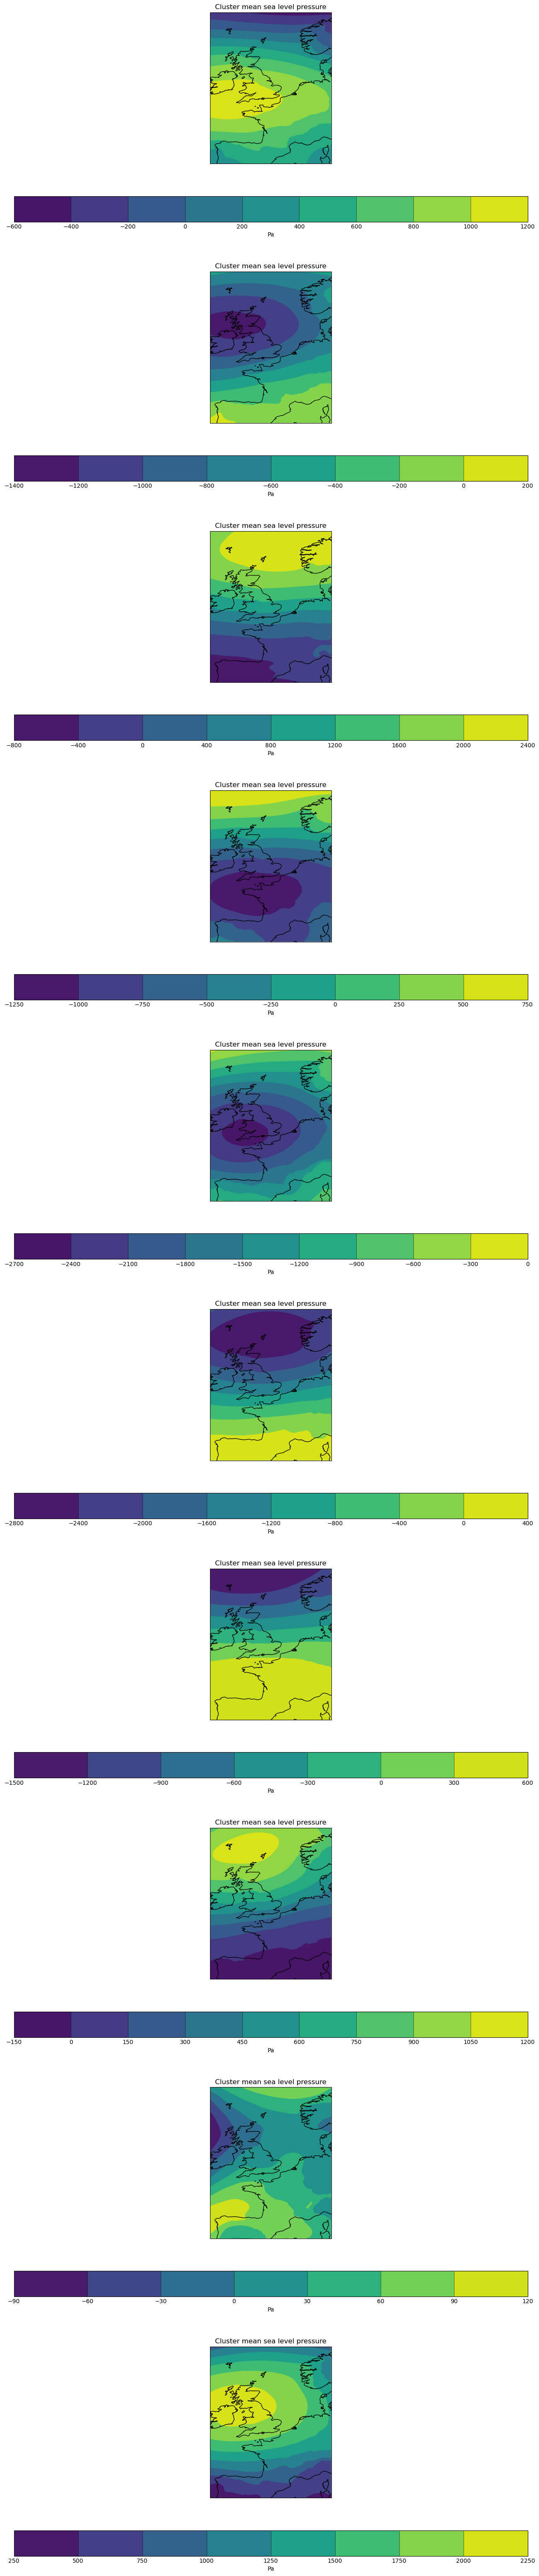

In [96]:
fig1 = matplotlib.pyplot.figure(figsize=(16,80))
for ix1 in range(num_clusters):
    ax1 = fig1.add_subplot(num_clusters,1,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(cluster_centres[ix1,:,:],axes=ax1)
    ax1.coastlines()    
    

In [97]:
season_clusters = [kmeans.predict(
    (era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2])) 
) for sn1 in range(4)]

In [98]:
season_names =['dfj (nh winter)', 'mam (nh spring)', 'jja (nh summer)','son (nh autumn)']

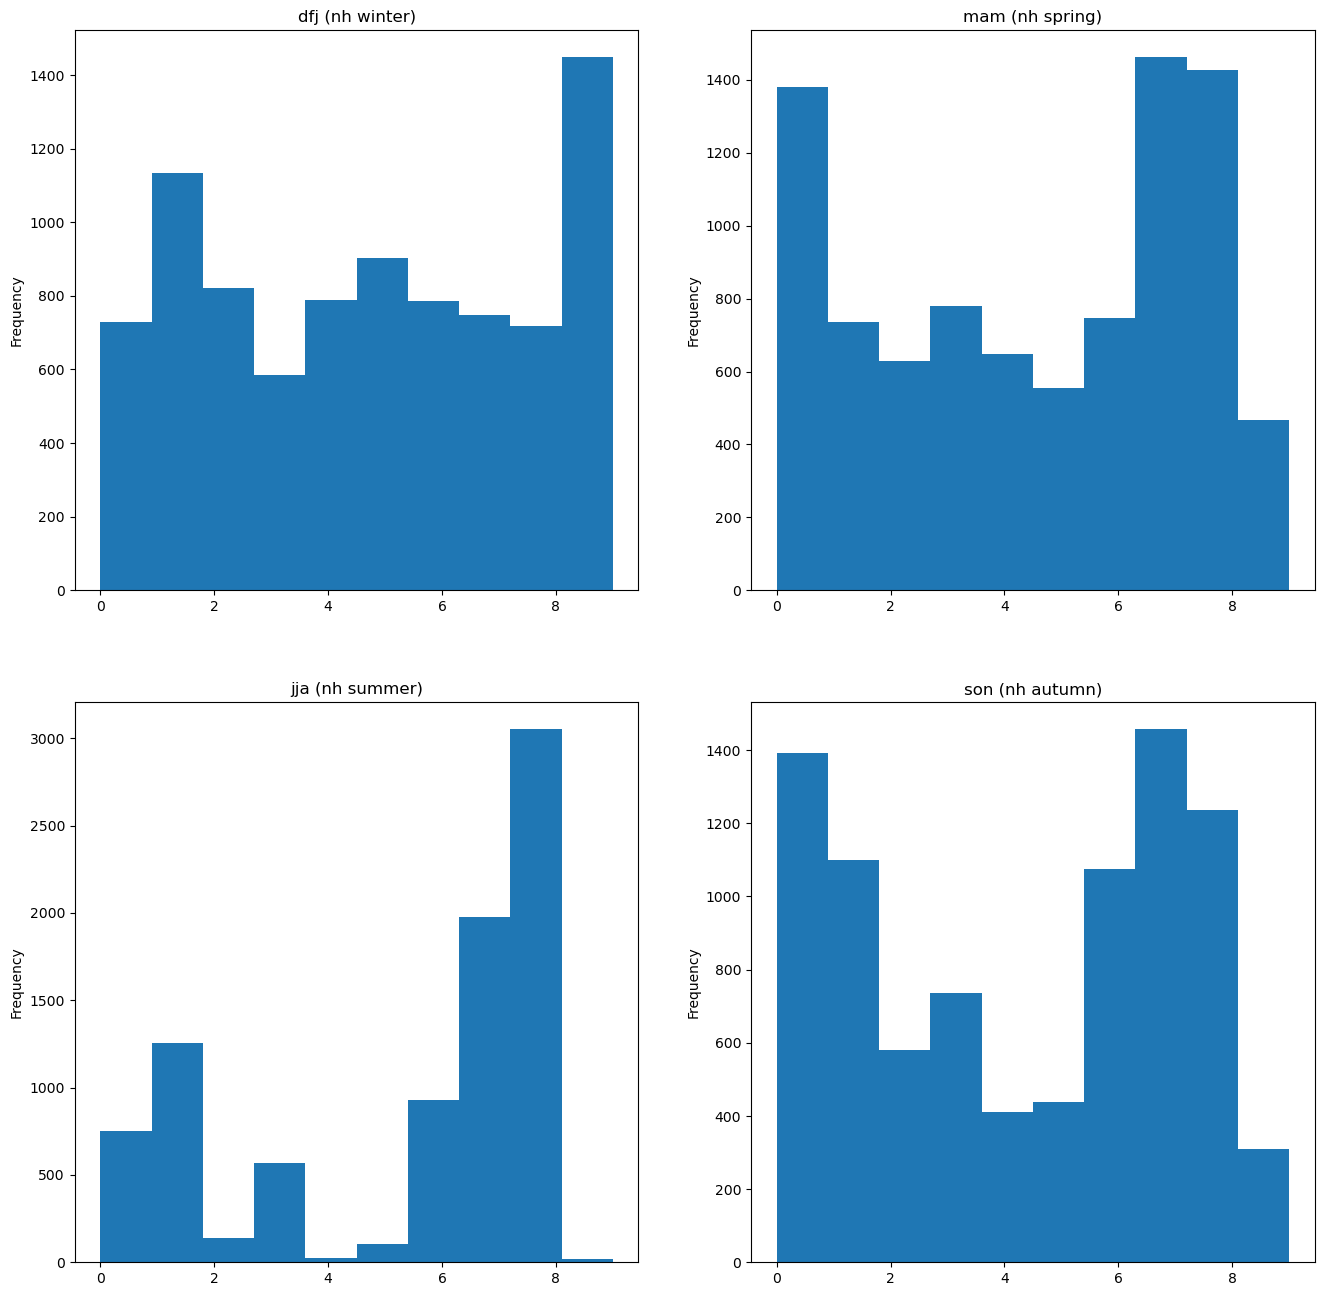

In [99]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for sn1, current_season in enumerate(season_clusters):
    ax1 = fig1.add_subplot(2,2,sn1+1, title=season_names[sn1])
    pandas.Series(current_season).plot.hist(ax=ax1)
    

### Another approach - dimensionality reduction

To improve clustering results, there are various ways of improving:
* change how to describe clusters
* change how to assign cluster membership
* change the distance metric between points
* transform the points into a different space, which may preseve some properties and change others, hopefully to improve separation.  

We will demonstrate this briefly by performing *principal component analysis* or *PCA*  on the data to reduce the dimensionality. This will also speed up calculation.

Scikit Learn reference:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [100]:
%%time 
pca_mslp = sklearn.decomposition.PCA(n_components=50, svd_solver='full')
pca_mslp.fit(era5_flat_deseasoned)

CPU times: user 17min 15s, sys: 4.84 s, total: 17min 20s
Wall time: 2min 21s


PCA(n_components=50, svd_solver='full')

In [101]:
era5_dim_reduced = pca_mslp.transform(era5_flat_deseasoned)

In [102]:
%%time
kmeans_mslp_reduced = sklearn.cluster.KMeans(n_clusters=num_clusters, random_state=0, max_iter=max_iter)
kmeans_mslp_reduced.fit(era5_dim_reduced)

CPU times: user 2.3 s, sys: 27.2 ms, total: 2.32 s
Wall time: 340 ms


KMeans(max_iter=1000, n_clusters=10, random_state=0)

In [103]:
cluster_centres_pca = iris.cube.Cube(
    data=(pca_mslp.inverse_transform(kmeans_mslp_reduced.cluster_centers_)).reshape((10,era5_mslp_cube.shape[1],era5_mslp_cube.shape[2],)),
    dim_coords_and_dims = [(cluster_coord, 0), (era5_mslp_cube.coord('latitude'),1), (era5_mslp_cube.coord('longitude'),2)],
    units=era5_mslp_cube.units,
    var_name='cluster_mean_sea_level_pressure',
)
    
    

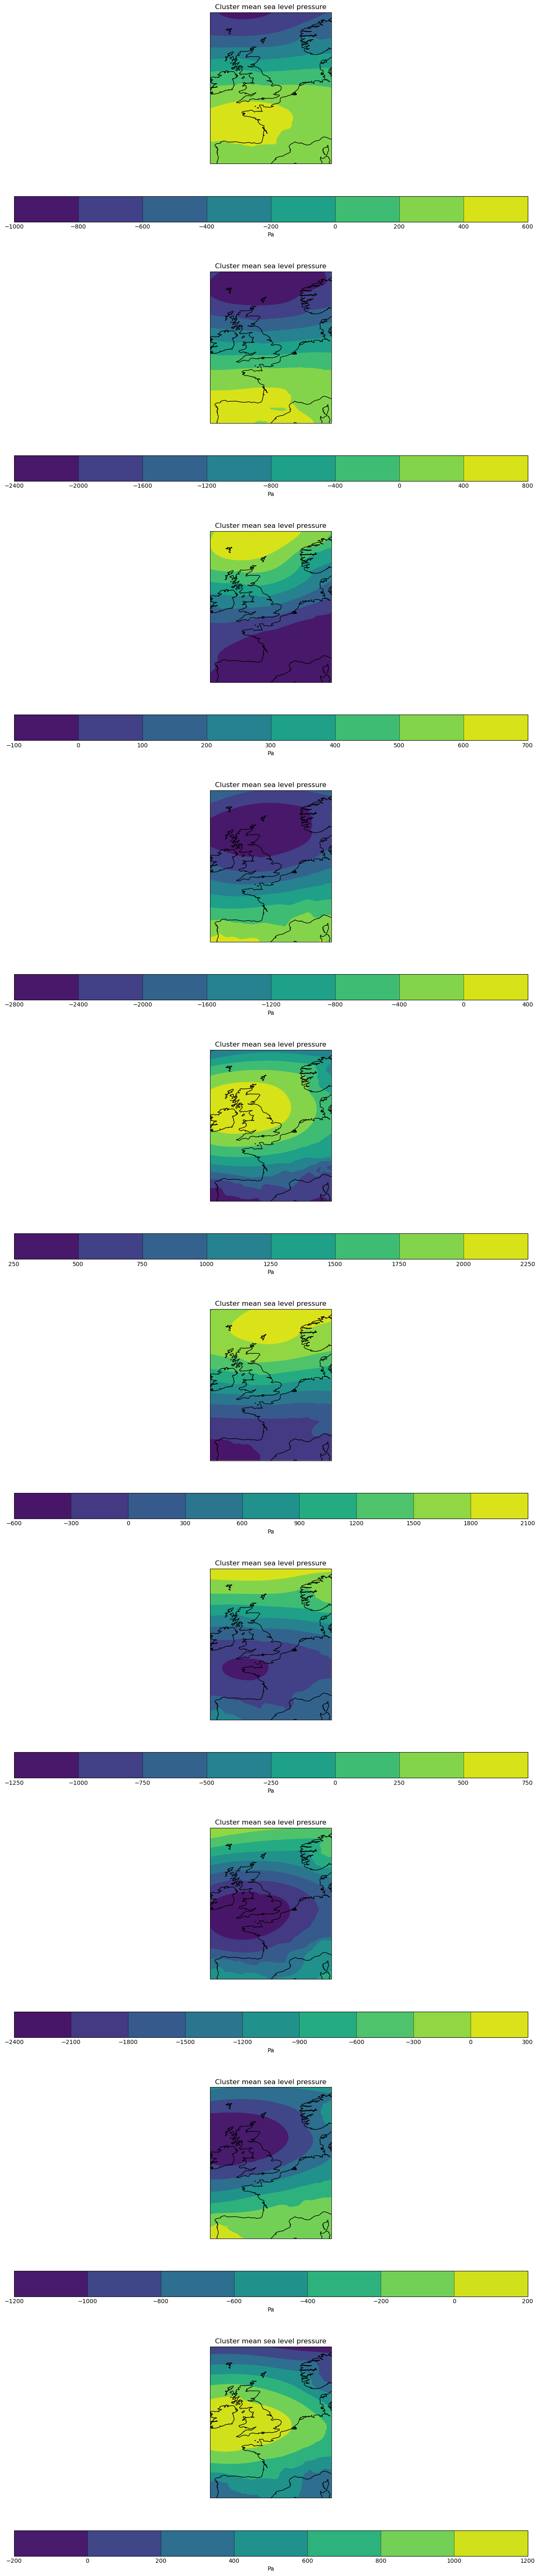

In [104]:
fig1 = matplotlib.pyplot.figure(figsize=(16,80))
for ix1 in range(num_clusters):
    ax1 = fig1.add_subplot(num_clusters,1,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(cluster_centres_pca[ix1,:,:],axes=ax1)
    ax1.coastlines()    


Now to calculate the clusters for each point we perform the following:
* remove the seasonal mean
* reshape the data
* apply PCA transform to reduce dimensionality
* predict which cluster each point belongs to

In [105]:
season_clusters_pca = [kmeans_mslp_reduced.predict( pca_mslp.transform(
    (era5_mslp_cube.extract(iris.Constraint(season_number=sn1)).data - season_average[sn1]).reshape(
    (-1, era5_mslp_cube.shape[1] * era5_mslp_cube.shape[2]))) 
) for sn1 in range(4)]

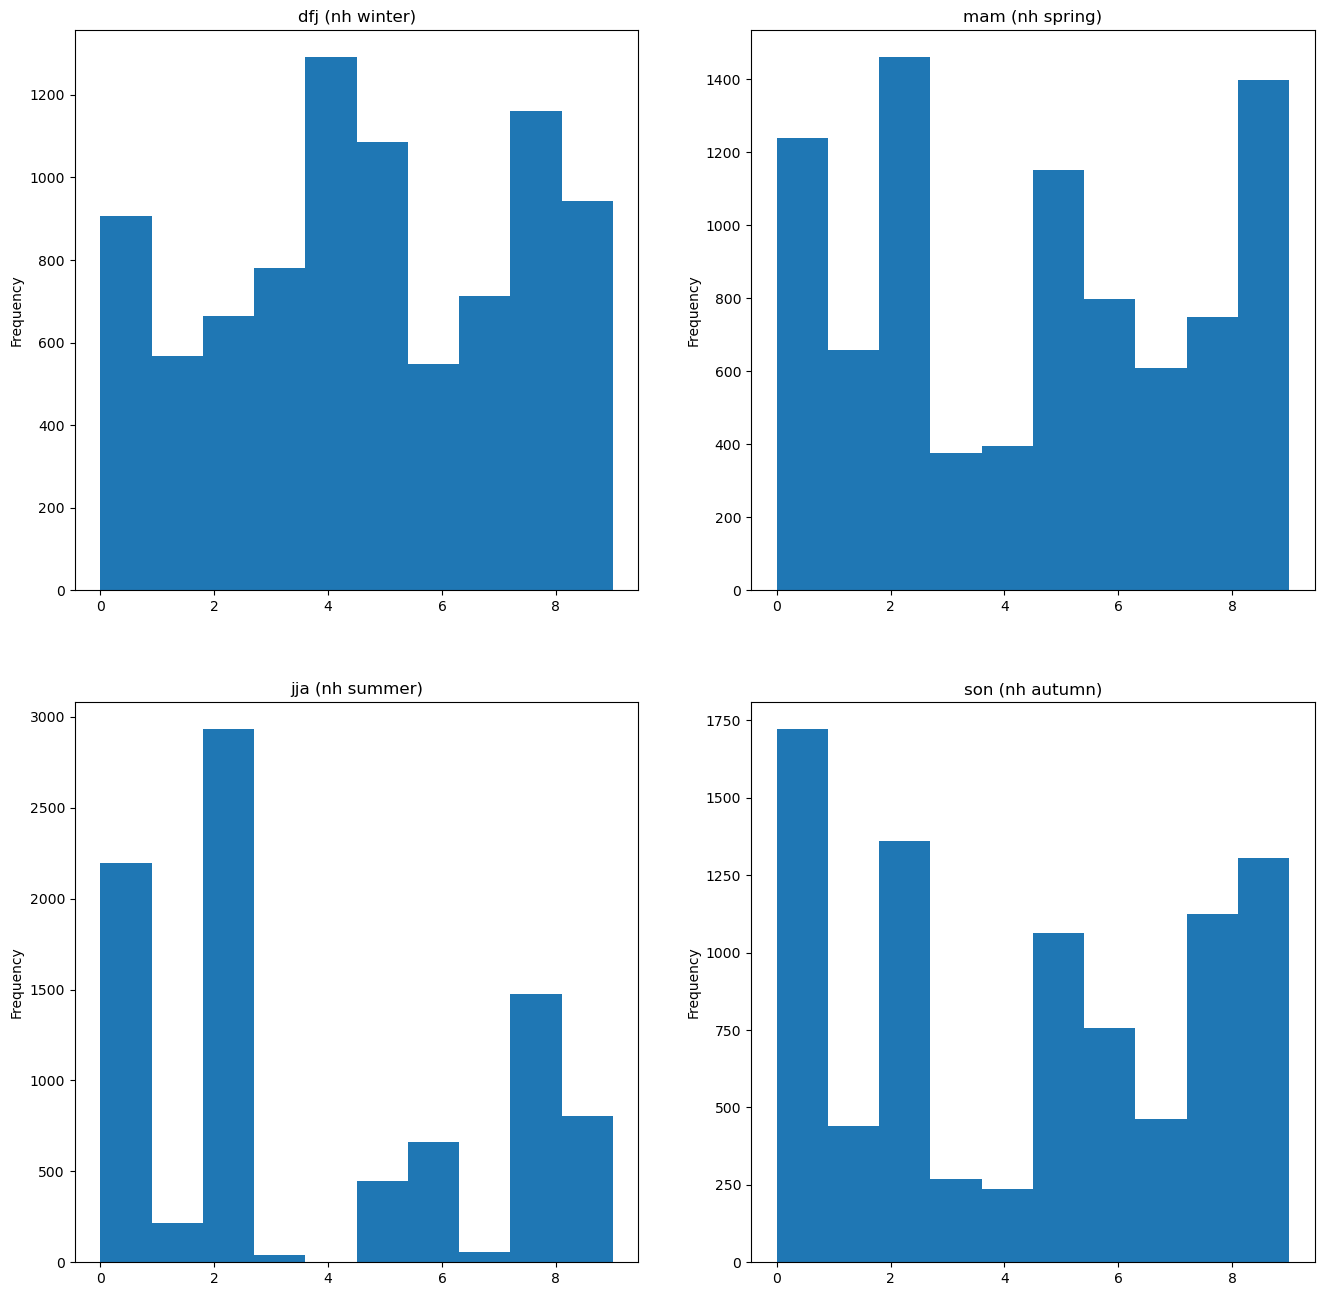

In [106]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for sn1, current_season in enumerate(season_clusters_pca):
    ax1 = fig1.add_subplot(2,2,sn1+1, title=season_names[sn1])
    pandas.Series(current_season).plot.hist(ax=ax1)
    

### Saving the model

Here we could very easily save the key parts of the steps and recreate them, to predict clusters on other data using our training outputs.
* The seasonal means
* The cluster centres
* The PCA transforms

In [107]:
pca_mslp.singular_values_

array([14662625.   ,  8368674.   ,  4803811.5  ,  3206283.2  ,
        2613854.8  ,  1565799.5  ,  1386963.4  ,  1142470.9  ,
         954315.25 ,   861201.7  ,   745311.75 ,   609653.94 ,
         557112.25 ,   538699.94 ,   454949.53 ,   447701.06 ,
         397193.75 ,   359990.44 ,   351121.34 ,   330920.62 ,
         321328.2  ,   270500.5  ,   250725.14 ,   243101.75 ,
         235520.9  ,   224388.86 ,   206088.81 ,   203427.42 ,
         196714.36 ,   187227.23 ,   175636.58 ,   172804.62 ,
         165626.7  ,   153026.17 ,   146490.66 ,   142709.27 ,
         137557.2  ,   134297.66 ,   130902.664,   125347.63 ,
         120279.84 ,   114934.57 ,   113605.13 ,   110202.72 ,
         108353.71 ,   103143.37 ,   100753.02 ,    99133.18 ,
          95976.15 ,    93734.47 ], dtype=float32)

In [108]:
pca_mslp.get_covariance().shape

(8181, 8181)

## Exercise 3 - Precipitaton prediction (Regression)

Now we will look at a pipeline for predicting precipitation, based on the *Precipitation Rediagnosis* dataset.

This code is taken from the [repository for the Preciptation Rediagnosis project](https://github.com/informatics-lab/precip_rediagnosis/).


In [109]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [110]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [111]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #'air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [112]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 


### Data Loading & Cleaning

In [113]:
try:
    prd_data_dir = pathlib.Path(os.environ['ML_TUTORIAL_DIR']) / 'prd'
except KeyError:
    prd_data_dir = pathlib.Path('/project/informatics_lab/data_science_cop/ml_tutorial/prd')
print(prd_data_dir.is_dir())
prd_data_dir

True


PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd')

In [114]:
prd_prefix_str = 'prd_merged'
prd_csv_suffix = 'csv'

In [115]:
prd_path_list = [p1 for p1 in prd_data_dir.rglob(f'{prd_prefix_str}*{prd_csv_suffix}')]
prd_path_list

[PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202008_storm_ellen/prd_merged_20200819T0600Z_20200822T1200Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202110_nswws_amber_oct/prd_merged_20211019T1800Z_20211021T0600Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202002_storm_dennis/prd_merged_20200214T1800Z_20200217T1800Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202112_storm_barra/prd_merged_20211206T1800Z_20211209T0600Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202102_nswws_amber_feb/prd_merged_20210219T0600Z_20210220T1800Z.csv'),
 PosixPath('/project/informatics_lab/data_science_cop/ml_tutorial/prd/202010_nswws_amber_oct/prd_merged_20201002T0000Z_20201004T1800Z.csv'),
 PosixPath('/project/informa

We will use two of the scenarios for training and reserve one scenario for testing.

In [116]:
prd_train_df = pandas.concat([pandas.read_csv(p1) for p1 in prd_path_list[:-1]])

In [117]:
prd_train_df

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,radar_fraction_in_band_aggregate_3hr_0.0,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101050.0,0.000000,...,0.000000,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101036.0,0.536442,...,0.000000,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.984375,0.0,101104.0,0.000000,...,0.000000,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,0.843750,0.0,101005.0,0.000000,...,0.000000,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2020-02-07 12:00:00,2020-02-07 18:00:00,1.000000,0.0,101038.0,0.000000,...,0.000000,0.807059,0.197647,0.0,0.0,0.463529,0.515294,0.025882,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160267,30,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.000000,0.0,99713.0,0.000000,...,0.052632,0.947368,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
160268,31,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.000000,0.0,99768.0,0.191107,...,0.052632,0.947368,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
160269,32,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.000000,0.0,99731.0,0.261515,...,0.052632,0.947368,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0
160270,33,58.78125,1.546875,0 days 06:00:00,2020-12-18 18:00:00,2020-12-19,1.000000,0.0,99684.0,0.492856,...,0.052632,0.947368,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0


### Feauture Engineering


In [118]:
prd_input_feature_names  = [c1 for c1 in prd_train_df.columns if 'temp' in c1] + [c1 for c1 in prd_train_df.columns if 'humid' in c1]

In [119]:
prd_target_feature_name = 'rainfall_rate'

In [120]:
prd_train_df[prd_input_feature_names]

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,relative_humidity_2750.0,relative_humidity_3000.0,relative_humidity_3250.0,relative_humidity_3500.0,relative_humidity_3750.0,relative_humidity_4000.0,relative_humidity_4500.0,relative_humidity_5000.0,relative_humidity_5500.0,relative_humidity_6000.0
0,285.0000,285.0000,285.000,284.9375,284.750,284.5625,284.375,283.9375,283.5625,283.1250,...,0.962891,0.947266,0.919922,0.909180,0.875977,0.774414,0.458984,0.245117,0.127930,0.142578
1,284.6875,284.6875,284.625,284.5625,284.375,284.1250,283.875,283.4375,283.0625,282.6250,...,1.006836,0.993164,0.961914,0.937500,0.803711,0.485352,0.126953,0.090820,0.118164,0.137695
2,284.6875,284.6875,284.625,284.5625,284.375,284.1875,284.000,283.5625,283.1875,282.7500,...,0.675781,0.707031,0.733398,0.761719,0.831055,0.861328,0.875000,0.799805,0.395508,0.284180
3,285.3125,285.3125,285.250,285.1875,285.000,284.8125,284.625,284.1875,283.8125,283.3750,...,0.665039,0.691406,0.697266,0.711914,0.604492,0.391602,0.110352,0.064453,0.082031,0.094727
4,284.6875,284.6875,284.625,284.5625,284.375,284.1875,284.000,283.5625,283.0625,282.6250,...,0.992188,0.952148,0.808594,0.442383,0.262695,0.207031,0.156250,0.102539,0.086914,0.053711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160267,283.5000,283.5625,283.625,283.5625,283.375,283.2500,283.125,282.9375,282.8125,282.7500,...,0.957031,0.883789,0.811523,0.754883,0.723633,0.740234,0.770508,0.815430,0.822266,0.809570
160268,282.4375,282.5000,282.625,282.5625,282.500,282.5000,282.500,282.5000,282.5625,282.6875,...,1.006836,0.995117,0.974609,0.959961,0.939453,0.919922,0.887695,0.858398,0.831055,0.805664
160269,282.7500,282.8125,282.875,282.8125,282.750,282.6875,282.625,282.4375,282.3125,282.2500,...,1.012695,0.995117,0.934570,0.887695,0.860352,0.844727,0.840820,0.843750,0.825195,0.808594
160270,283.3125,283.3125,283.375,283.3125,283.125,283.0625,283.000,282.8750,282.7500,282.6250,...,0.989258,0.986328,0.981445,0.972656,0.947266,0.919922,0.860352,0.799805,0.753906,0.726562


In [121]:
prd_train_df[prd_target_feature_name]

0         0.000000
1         0.536442
2         0.000000
3         0.000000
4         0.000000
            ...   
160267    0.000000
160268    0.191107
160269    0.261515
160270    0.492856
160271    0.124052
Name: rainfall_rate, Length: 2316476, dtype: float64

### Data Preparation


In [122]:
prd_preproc_dict = {}
for if1 in prd_input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(prd_train_df[[if1]])
    prd_preproc_dict[if1] = scaler1

In [123]:
prd_target_scaler = sklearn.preprocessing.MinMaxScaler()
prd_target_scaler.fit(prd_train_df[[prd_target_feature_name]])


MinMaxScaler()

In [124]:
prd_X_train = preproc_input(prd_train_df, prd_preproc_dict)
prd_y_train = prd_target_scaler.transform(prd_train_df[[prd_target_feature_name]])

In [125]:
prd_X_train.shape, prd_y_train.shape

((2316476, 66), (2316476, 1))

In [126]:
prd_test_df = pandas.concat([pandas.read_csv(p1) for p1 in prd_path_list[-1:]])

In [127]:
# normalise temp and humidity features

In [128]:
prd_test_df

,time,latitude,longitude,radar_max_rain_aggregate_3hr,radar_mean_rain_aggregate_3hr,radar_max_rain_instant,radar_mean_rain_instant,fraction_sum_agg,fraction_sum_instant,radar_fraction_in_band_aggregate_3hr_0.0,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,29.6250,29.6875,29.5625,29.3750,29.3125,29.5625,32.3750,36.6875,42.1875,51.4375
1,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,29.2500,29.0625,28.9375,29.3125,30.3750,32.1875,37.5625,43.0625,49.2500,54.0625
2,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,32.5625,33.3750,34.6250,36.1250,37.6875,39.3750,40.6875,40.4375,42.8750,52.0625
3,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,31.0625,32.0000,33.1250,34.2500,35.5625,37.1250,40.0000,40.9375,43.7500,52.3750
4,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,32.8750,32.6875,33.1875,33.8125,34.1875,34.1875,35.0000,35.5000,40.0000,52.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347251,2022-02-21 12:00:00,58.78125,1.546875,0.000000,0.000000,0.00000,0.00000,1.0,1.000000,1.000000,...,22.2500,21.9375,21.6875,21.3750,20.8125,20.3125,22.6875,24.6875,24.0000,23.2500
347252,2022-02-21 12:00:00,58.78125,1.546875,0.000000,0.000000,0.00000,0.00000,1.0,1.000000,1.000000,...,22.4375,21.3125,20.3125,19.9375,19.9375,19.8125,20.2500,22.8750,24.5000,24.8125
347253,2022-02-21 12:00:00,58.78125,1.546875,0.000000,0.000000,0.00000,0.00000,1.0,1.000000,1.000000,...,18.5000,17.8750,17.5625,17.6875,17.8750,18.1250,18.8125,21.6250,23.0000,23.6250
347254,2022-02-21 12:00:00,58.78125,1.546875,0.000000,0.000000,0.00000,0.00000,1.0,1.000000,1.000000,...,22.6250,20.8750,19.8750,19.7500,20.0000,20.0000,20.1875,23.1250,24.8125,25.1875


In [129]:
prd_X_test = preproc_input(prd_test_df, prd_preproc_dict)
prd_y_test = prd_target_scaler.transform(prd_test_df[[prd_target_feature_name]])

In [130]:
prd_X_test.shape, prd_y_test.shape

((347256, 66), (347256, 1))

In [131]:
prd_tuples = [
    (prd_X_train, prd_y_train),
    (prd_X_test, prd_y_test),    
]

### Algorithm Setup

In [132]:
prd_classifiers_params = {
    'random_forest': {'class': sklearn.ensemble.RandomForestRegressor, 'opts': {'max_depth':10, }},
     'ann_5_500': {'class': sklearn.neural_network.MLPRegressor, 'opts': {'hidden_layer_sizes':(500,500,500,500,500)}},   
}

In [133]:
%%time
prd_classifiers_dict = {}             
for clf_name, clf_params in prd_classifiers_params.items():
    clf1 = clf_params['class'](**clf_params['opts'])
    prd_classifiers_dict[clf_name] = clf1

CPU times: user 241 µs, sys: 0 ns, total: 241 µs
Wall time: 253 µs


## Algorithm Training

In [134]:
num_training_samples = 50000

In [135]:
%%time
for clf_name, clf1 in prd_classifiers_dict.items():
    print(clf_name)
    clf1.fit(prd_X_train[:num_training_samples,:], prd_y_train[:num_training_samples])


random_forest
ann_5_500
CPU times: user 18min 41s, sys: 1.2 s, total: 18min 42s
Wall time: 4min 1s


### Inference

In [136]:
prd_y_pred_train = {}

for clf_name, clf1 in prd_classifiers_dict.items():
    prd_y_pred = clf1.predict(prd_X_train)
    prd_y_pred_train[clf_name] = prd_y_pred
    prd_train_df[f'pred_{clf_name}'] = prd_y_pred

In [137]:
prd_y_pred_test= {}

for clf_name, clf1 in prd_classifiers_dict.items():
    prd_y_pred = clf1.predict(prd_X_test)
    prd_y_pred_test[clf_name] = prd_y_pred
    prd_test_df[f'pred_{clf_name}'] = prd_y_pred

### Evaluation

In [138]:
prd_test_rmse = sklearn.metrics.mean_squared_error(
    prd_y_test,
    prd_classifiers_dict['ann_5_500'].predict(prd_X_test))
prd_test_rmse

0.00013971873729463604

### Caveats for this example

This is a very naive solution to this problem, and it is giving us bad results. This is not a surprise, as precipitation is generally considered a very difficult field to predict using any approach. We will look at a more sophisticated approach in the next notebook.

## Examples of use
* You can see more example notebook relating to this challenge on the [Data Science CoP GitHub repository](https://github.com/MetOffice/data_science_cop/tree/master/challenges/2021_falklands_rotors).

More Information on Weather Patterns can be found here, which the full much more sophisticated technique used in the real application:
* [Met Office Info Page on Weather Types](https://www.metoffice.gov.uk/research/news/2016/new-weather-patterns-for-uk-and-europe)
* [Paper by Neal, Fereday et al.](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/met.1563)
 


## Next steps

* [Rotors Challenge Notebooks](https://github.com/MetOffice/data_science_cop/tree/master/challenges/2021_falklands_rotors) 
* [Leeds University Notebooks](https://cemac.github.io/LIFD_ENV_ML_NOTEBOOKS/) 
* [Kaggle Weather Types Clustering Competition](https://www.kaggle.com/code/prakharrathi25/weather-data-clustering-using-k-means/notebook)


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meterologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.

### ERA5
ERA5 is Renanlysis data created by ECMWF. Reanalysis combines observations from many sources by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

### Precipitation Rediagnosis
This dataset was created as part of a Met Office project, which is documented on the [GitHub Repository](https://github.com/informatics-lab/precip_rediagnosis)


## References

The format of this notebook is based on the [template for tutorial notebooks](https://github.com/geo-yrao/notebook-dev/blob/main/templates/NCAI_Training_Notebook_template%20-%20Distribution%20Copy.ipynb) developed by NOAA, available on GitHub.